In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import xarray as xr
sys.path.insert(0, os.path.abspath('../src'))
from rice_vapor import RiceVapor

In [2]:
rv_data = xr.open_mfdataset('input/qvapor_slice.nc', combine='by_coords')
nz = len(rv_data.bottom_top) * 0.8
rv = RiceVapor(rv_data, num_obs=20, z=nz)

In [3]:
rv.set_num_rays(10)
rv.num_rays
rv.compute_obs()

- first compute, angles being saved for future computation


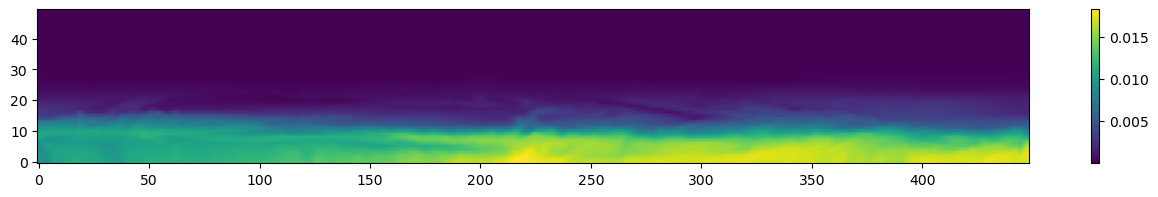

In [4]:
rv.plot_env()

In [6]:
help(RiceVapor)

Help on class RiceVapor in module rice_vapor:

class RiceVapor(builtins.object)
 |  RiceVapor(qvapor, num_obs, z, y=0, time=-1, num_rays=0)
 |  
 |  A class used to hold an object for calculating water vapor line integrals
 |  from model data to test reproduction.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, qvapor, num_obs, z, y=0, time=-1, num_rays=0)
 |      Parameters
 |      ----------
 |      qvapor: 2 dimensional input water vapor field
 |      num_obs: number of observation points from above
 |      z: height of observations
 |      y: (default is 0)
 |      time: time step to retrieve input from dataset or dataarray
 |            (default is -1)
 |      num_rays: (default is 0)
 |  
 |  __repr__(self)
 |      Return repr(self).
 |  
 |  compute_ob(self, ob_i, ob_location)
 |  
 |  compute_ob_line(self, ob_i, ob_location)
 |  
 |  compute_obs(self)
 |  
 |  copy_rv_setup(self, rv)
 |  
 |  get_target_end(self)
 |  
 |  get_target_start(self)
 |  
 |  get_target_window